# importing necessary libraries

In [1]:
import os, random                                                                   # for handelling the files
import numpy as np                                                                  # working with arrays and data manupilation
import pandas as pd
import json
import matplotlib.pyplot as plt                                                     # plotting  
import seaborn as sns                                                               # another data visualizor(improves matp)

from glob import glob                                                               # for handelling file paths
from pathlib import Path                                                            # for handelling file paths
from natsort import natsorted                                                       # for sorting files
from tqdm.auto import tqdm                                                          # for asthetic for loops :)
from collections import Counter                                                     # drawing charts


from sklearn.model_selection import train_test_split                                # splitting the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch, torchvision, torchmetrics, torchinfo
import torch.optim as optim                                                         # optimizer
import torch.nn.functional as F                                                     # loss function

from torch import nn                                                                # building neural networks
from torch.utils.data import Dataset                                                # building dataset objects
from torch.utils.data import DataLoader                                             # building data loaders to feed the data to model
from torch.utils.tensorboard import SummaryWriter                                   # for tracking model performance(easy to use)
from torchvision import transforms                                                  # for changes to the dataset content
from torchinfo import summary                                                       # gives a summery of model structure

In [3]:
import cv2                                                                          # for opening the video files
import mediapipe as mp                                                              # for detecting landmarks

check if CUDA is available

In [4]:
if torch.cuda.is_available():
    print("Cuda is available.")
    print(f"Current Device: {torch.cuda.current_device()}, Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available.
Current Device: 0, Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
holistic_model= mp.solutions.holistic
draw_utils= mp.solutions.drawing_utils

I decided to use **LSA64: A Dataset for Argentinian Sign Language**:<br>
**The sign database** for the Argentinian Sign Language, created with the goal of producing a dictionary for LSA and training an automatic sign recognizer, **includes 3200 videos where 10 non-expert subjects executed 5 repetitions of 64 different types of signs**. Signs were selected among the most commonly used ones in the LSA lexicon, including both verbs and nouns.<br>

- I tried to capture detections for the entire dataset but it took around 3 hours. and at the end i had to change the code because i forgot to add a list that would represent the essence of the video in terms of being a sequence of detected frame landmarks.

- As seen in the picture below a good number of video samples involve using right hand. after my first experiment as a concept I decided to eliminate detections for left hands because i was only using the first 10 words. and leaving left hand detections created a lot of zeros which i believe were effecting my lstm perfomance.


![Image Description](lsa64_raw/Images/datasetgeneralinfo.png)

In [6]:
root= 'lsa64_raw/all'
save_directory= 'lsa64_raw/all_results/'
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

# Function to extract detections from all videos in our dataset

In [7]:
def get_landmarks(root: str, class_names, frame_numbers):
    
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []
    detections= []
    labels= []
    frame_numbers= frame_numbers
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
            else:                                           # if cap can read the video
                total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
                frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
                video_detections= []
                for idx in frame_idxs_to_process:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame= cap.read()
            
                    result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                    face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                    lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                    rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                    detection= np.concatenate((pose,face,lh, rh))
                    label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                    video_detections.append(detection)

                
                detections.append(video_detections)    
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                labels.append(label)
   
            cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

# Function to train Models

In [8]:
def train(num_epochs, model, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device):
    train_losses, test_losses, train_accuracies, test_accuracies= [], [], [], []
 
    for epoch in tqdm(range(num_epochs), desc="Training Epoch"):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0

        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_accuracy += calculate_accuracy(outputs, labels)
        
        train_losses.append(train_loss / len(train_dataloader))
        train_accuracies.append(train_accuracy / len(train_dataloader))
    
        model.eval()
        all_preds, all_labels= [], []
        test_loss, test_accuracy= 0.0, 0.0
        
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                test_accuracy += calculate_accuracy(outputs, labels)
                
                _, preds = torch.max(outputs, 1)                  # Get the predicted labels
                all_preds.extend(preds.view(-1).cpu().numpy())    # Store predictions
                all_labels.extend(labels.view(-1).cpu().numpy())  # Store true labels
                
        
        test_losses.append(test_loss / len(test_dataloader))
        test_accuracies.append(test_accuracy / len(test_dataloader))
        #print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

    return train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels

# Function to calculate accuracies

In [9]:
def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

# Function to draw loss and accuracy of the model

In [10]:
def draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size):
    train_accuracies_cpu = [x.cpu().item() for x in train_accuracies] 
    test_accuracies_cpu = [x.cpu().item() for x in test_accuracies]
    
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')  # or use train_losses_cpu if converted
    plt.plot(test_losses, label='Validation Loss')  # or use test_losses_cpu if converted
    plt.title(f'Loss over Epochs(batch size= {batch_size})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies_cpu, label='Training Accuracy')
    plt.plot(test_accuracies_cpu, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to draw confusion matrix of the model

In [11]:
def draw_confmatrix(all_labels, all_preds, class_names, num_epochs):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(18, 15))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix after {num_epochs} epoches')
    plt.show()

In [12]:
#result= get_landmarks(root, class_names, 60)

# Saving/Loading detections and labels

In [13]:
#np.save(os.path.join(save_directory, 'detections60fps.npy'), np.array(result[0]))     # saving detection 
#with open(os.path.join(save_directory, 'labels50fps.json'), 'w') as file:
    #json.dump(result[1], file)                                                   # saving labels

In [34]:
detections= np.load(os.path.join(save_directory, 'detections40fps.npy'), allow_pickle=True)
with open(os.path.join(save_directory, 'labels40fps.json'), 'r') as file:
    labels= json.load(file)

In [35]:
detections.shape

(3200, 40, 1662)

# Preparing data

In [39]:
label_map= {label: num for num, label in enumerate(class_names)}

X_train, X_test, y_train, y_test = train_test_split(detections, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_test= torch.tensor(X_train, dtype=torch.float32) , torch.tensor(X_test, dtype=torch.float32)

y_train= [label_map[label] for label in y_train]
y_test= [label_map[label] for label in y_test]
y_train= torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2560, 40, 1662]),
 torch.Size([640, 40, 1662]),
 torch.Size([2560]),
 torch.Size([640]))

# Custom class for dataset

In [40]:
class CustomDataset(Dataset):
    def __init__(self,features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [41]:
train_dataset= CustomDataset(X_train, y_train)
test_dataset= CustomDataset(X_test, y_test)

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class for LSTM Model

I built the LSTM model based on a youtube video i saw. in the video the model is made using TensorFlow. Here I implemented the same model using PyTorch

In [20]:
class LstmModel(nn.Module):
    def __init__(self, input_size= 1662, hidden_size= 96, num_classes= 64):
        super().__init__()
        # Define the LSTM layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        #self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        # Define the Dense layers
        self.dense1 = nn.Linear(hidden_size, num_classes)
        #self.dense2 = nn.Linear(hidden_size, num_classes)

        # Define activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (hn, cn) = self.lstm1(x)
        #x = self.relu(x)
        #x, (hn, cn) = self.lstm2(x)
        #x = self.relu(x)

        x = x[:, -1, :] # here we make x the last prediction of the model beacuse i want to do classification

        self.dense1(x)
        #x = self.dense2(x) 
        return x

In [21]:
test_model= LstmModel().to(device)
summary(test_model, input_size=(1, 40, 1662)) # summery of the model's structure

Layer (type:depth-idx)                   Output Shape              Param #
LstmModel                                [1, 96]                   --
├─LSTM: 1-1                              [1, 40, 96]               675,840
├─Linear: 1-2                            [1, 64]                   6,208
Total params: 682,048
Trainable params: 682,048
Non-trainable params: 0
Total mult-adds (M): 27.04
Input size (MB): 0.27
Forward/backward pass size (MB): 0.03
Params size (MB): 2.73
Estimated Total Size (MB): 3.03

# Class for transformer model (with positional encoding)

In [36]:
class TransformerModelP(nn.Module):
    def __init__(self, num_classes= 64, seq_len=40, landmarks=1662, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()

        self.seq_len = seq_len
        self.landmarks = landmarks
        self.input_proj = nn.Linear(landmarks, hidden_dim)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.linear_class = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.shape
        inputs_proj = self.input_proj(inputs.view(batch_size * seq_len, -1)).view(batch_size, seq_len, -1)
        
        # Adding positional encodings
        inputs_encoded = inputs_proj + self.pos_encoder
        
        # Passing through the transformer encoder
        transformer_output = self.transformer_encoder(inputs_encoded)
        
        # Using only the output from the last time step for classification
        output = self.linear_class(transformer_output[:, -1, :])
        
        return output

In [37]:
test_model = TransformerModelP().to(device)
summary(test_model, input_size=(1, 40, 1662))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModelP                             [1, 64]                   5,120
├─Linear: 1-1                                 [40, 128]                 212,864
├─TransformerEncoder: 1-2                     [1, 40, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 40, 128]              593,024
│    │    └─TransformerEncoderLayer: 3-2      [1, 40, 128]              593,024
├─Linear: 1-3                                 [1, 64]                   8,256
Total params: 1,412,288
Trainable params: 1,412,288
Non-trainable params: 0
Total mult-adds (M): 8.52
Input size (MB): 0.27
Forward/backward pass size (MB): 0.04
Params size (MB): 0.88
Estimated Total Size (MB): 1.19

# Class for transformer model (with Conv1D layer)

In [24]:
class TransformerModelC(nn.Module):
    def __init__(self, num_classes=64, seq_len=40, landmarks=1662, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        
        self.seq_len = seq_len
        self.landmarks = landmarks
        self.input_proj = nn.Conv1d(in_channels=landmarks, out_channels=hidden_dim, kernel_size=1)
        # self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_class = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs):
        batch_size, seq_len, _ = inputs.shape
        inputs_reshaped = inputs.permute(0, 2, 1)
        inputs_proj = self.input_proj(inputs_reshaped)
        inputs_proj = inputs_proj.permute(0, 2, 1)
        
        #inputs_encoded = inputs_proj + self.pos_encoder
        
        transformer_output = self.transformer_encoder(inputs_proj)
        
        output = self.linear_class(transformer_output[:, -1, :])
        
        return output

In [25]:
test_model = TransformerModelC().to(device)
summary(test_model, input_size=(1, 40, 1662))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModelC                             [1, 64]                   --
├─Conv1d: 1-1                                 [1, 128, 40]              212,864
├─TransformerEncoder: 1-2                     [1, 40, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 40, 128]              593,024
│    │    └─TransformerEncoderLayer: 3-2      [1, 40, 128]              593,024
├─Linear: 1-3                                 [1, 64]                   8,256
Total params: 1,407,168
Trainable params: 1,407,168
Non-trainable params: 0
Total mult-adds (M): 8.52
Input size (MB): 0.27
Forward/backward pass size (MB): 0.04
Params size (MB): 0.88
Estimated Total Size (MB): 1.19

# Class for transformer model (No positional encoding)

In [26]:
class TransformerModel(nn.Module):
    def __init__(self, num_classes=64, seq_len=40, landmarks=1662, nhead=6, num_layers=2):
        super().__init__()
        
        self.seq_len = seq_len
        self.landmarks = landmarks
        #self.input_proj = nn.Conv1d(in_channels=landmarks, out_channels=hidden_dim, kernel_size=1)
        # self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, hidden_dim))
        encoder_layer = nn.TransformerEncoderLayer(d_model=landmarks, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear_class = nn.Linear(landmarks, num_classes)

    def forward(self, inputs):
        #batch_size, seq_len, _ = inputs.shape
        #inputs_reshaped = inputs.permute(0, 2, 1)
        #inputs_proj = self.input_proj(inputs_reshaped)
        #inputs_proj = inputs_proj.permute(0, 2, 1)
        
        #inputs_encoded = inputs_proj + self.pos_encoder
        
        transformer_output = self.transformer_encoder(inputs)
        
        output = self.linear_class(transformer_output[:, -1, :])
        
        return output

In [27]:
test_model = TransformerModel().to(device)
summary(test_model, input_size=(1, 40, 1662))

Layer (type:depth-idx)                        Output Shape              Param #
TransformerModel                              [1, 64]                   --
├─TransformerEncoder: 1-1                     [1, 40, 1662]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 40, 1662]             17,873,534
│    │    └─TransformerEncoderLayer: 3-2      [1, 40, 1662]             17,873,534
├─Linear: 1-2                                 [1, 64]                   106,432
Total params: 35,853,500
Trainable params: 35,853,500
Non-trainable params: 0
Total mult-adds (M): 0.11
Input size (MB): 0.27
Forward/backward pass size (MB): 0.00
Params size (MB): 0.43
Estimated Total Size (MB): 0.69

# Class for random forest

In [28]:
x_train_reshaped = torch.reshape(X_train, (2560, -1))
x_test_reshaped = torch.reshape(X_test, (640, -1))

random_forest_model = RandomForestClassifier(n_estimators=10, random_state=42, max_depth= 64**3)
random_forest_model.fit(x_train_reshaped, y_train)

RandomForestClassifier(max_depth=262144, n_estimators=10, random_state=42)

# Training the models and analysing the results

# 1. LSTM

In [43]:
num_epochs= 100
batch_size= 128
learning_rate= 0.0001

lstm_model= LstmModel().to(device)                                   # initialize model

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, lstm_model, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

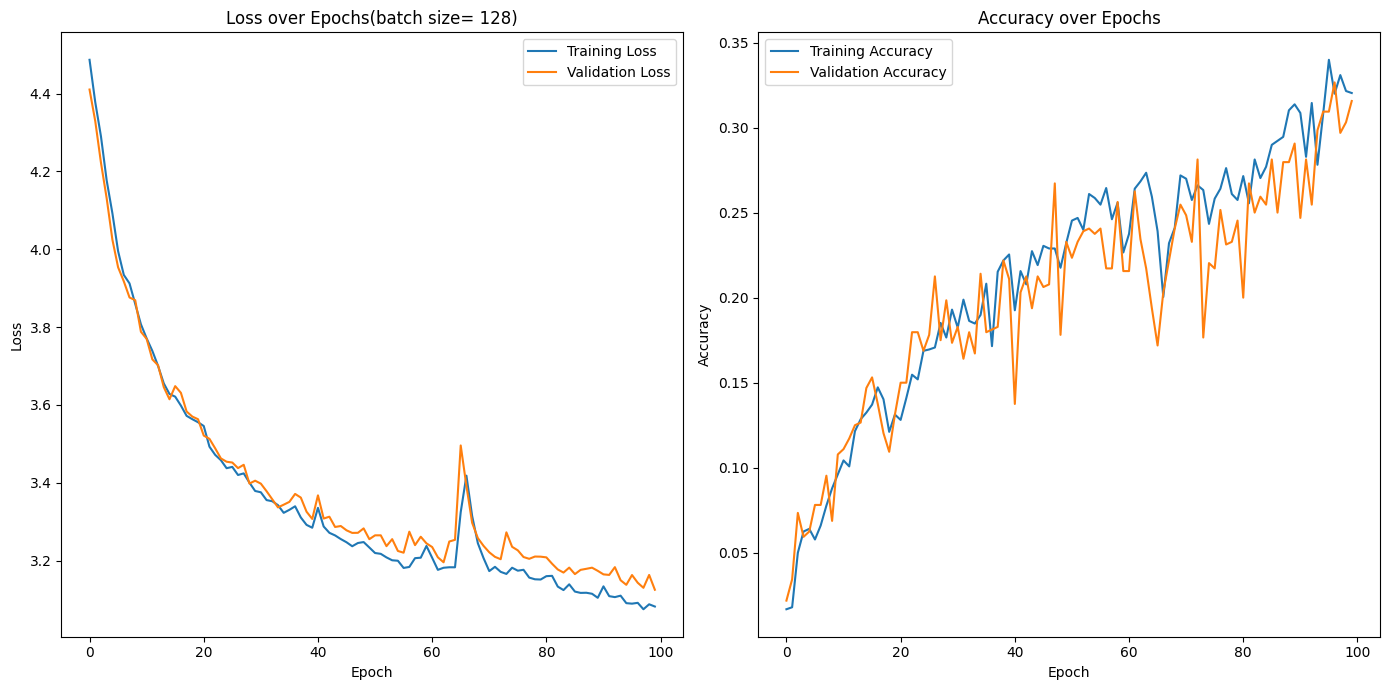

In [44]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

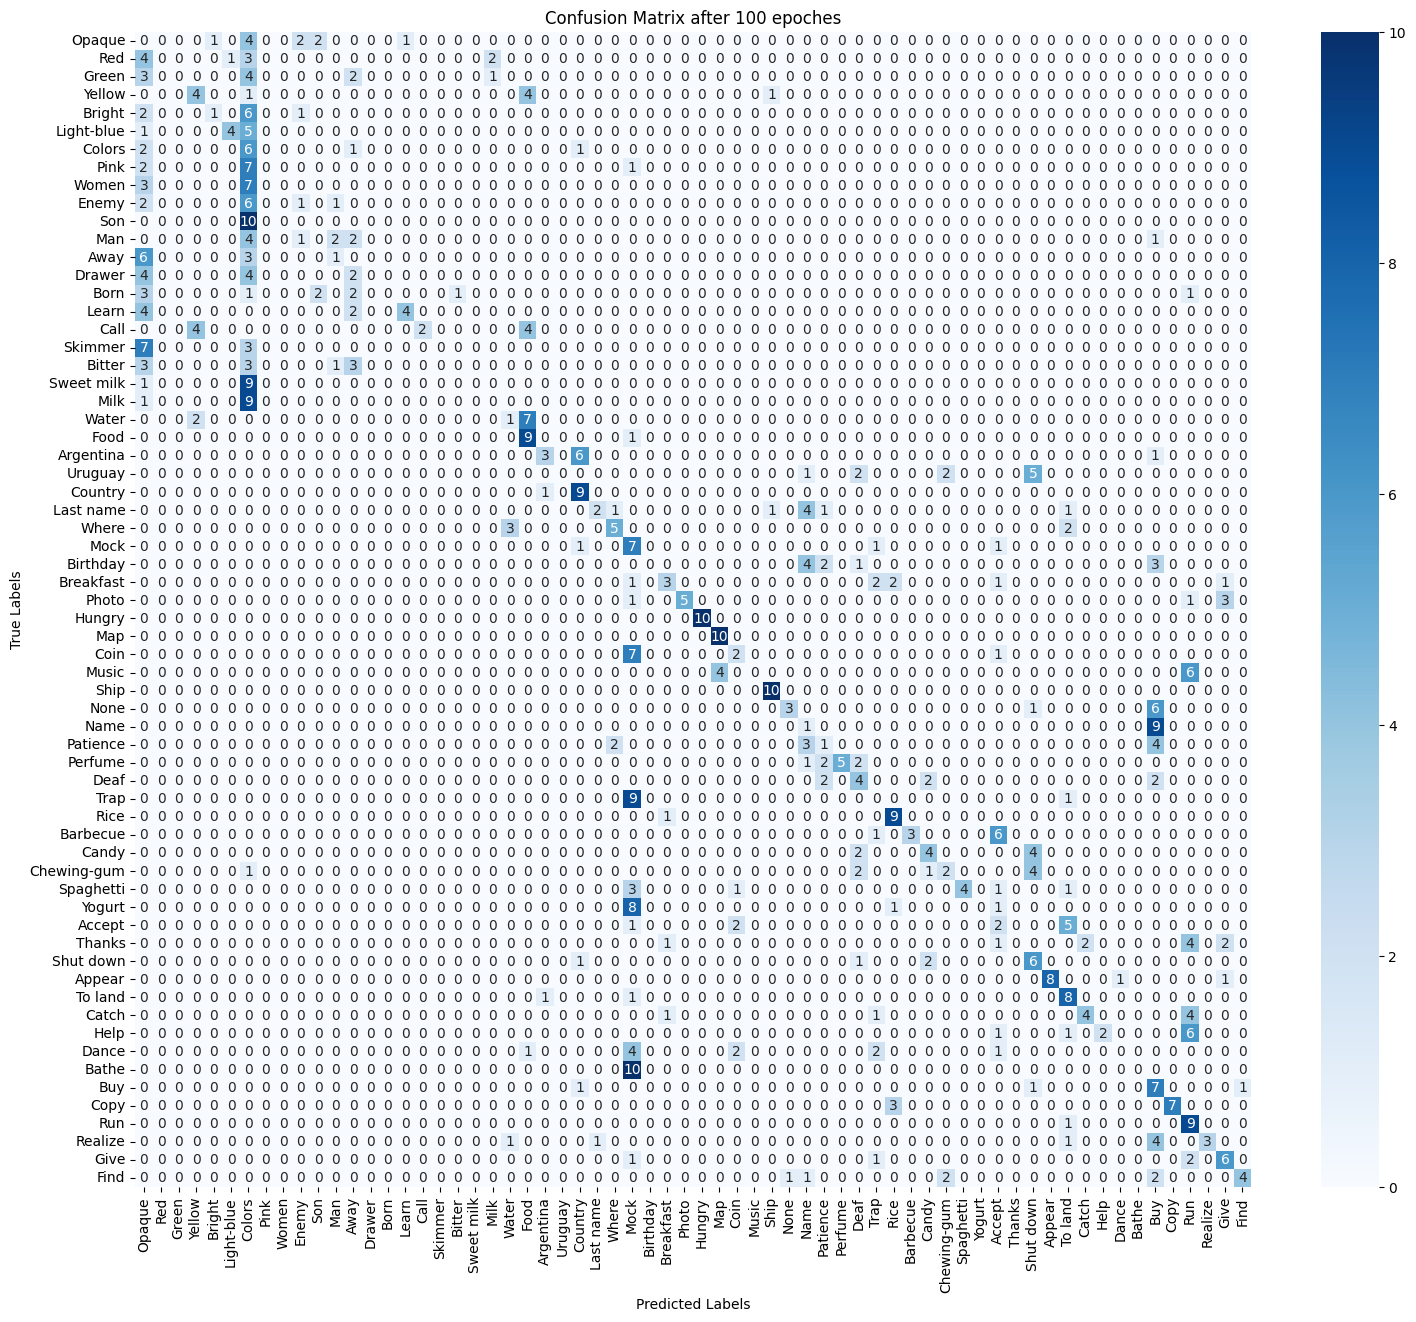

In [45]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)

# 2. Transformer with positional encoding

In [46]:
num_epochs= 120
batch_size= 64
learning_rate= 0.0001

transformer_modelp= TransformerModelP().to(device)                  # initialize 

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_modelp.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, transformer_modelp, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

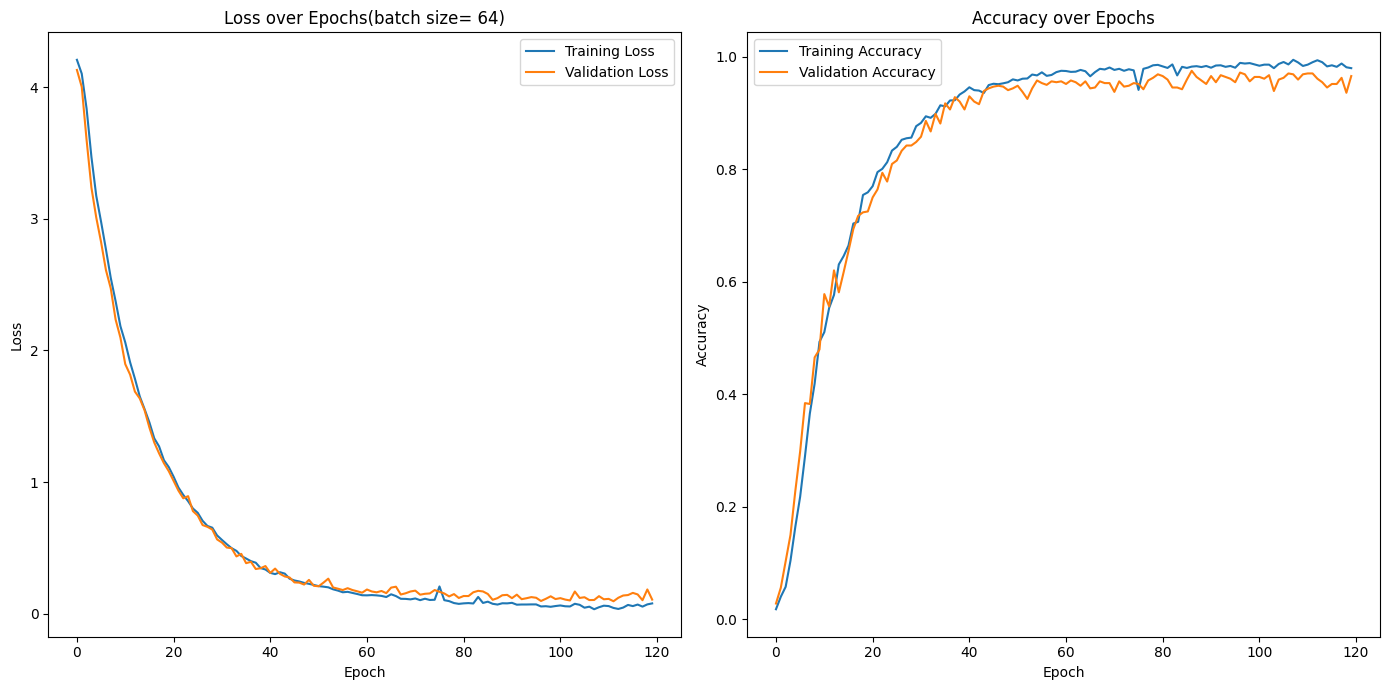

In [47]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

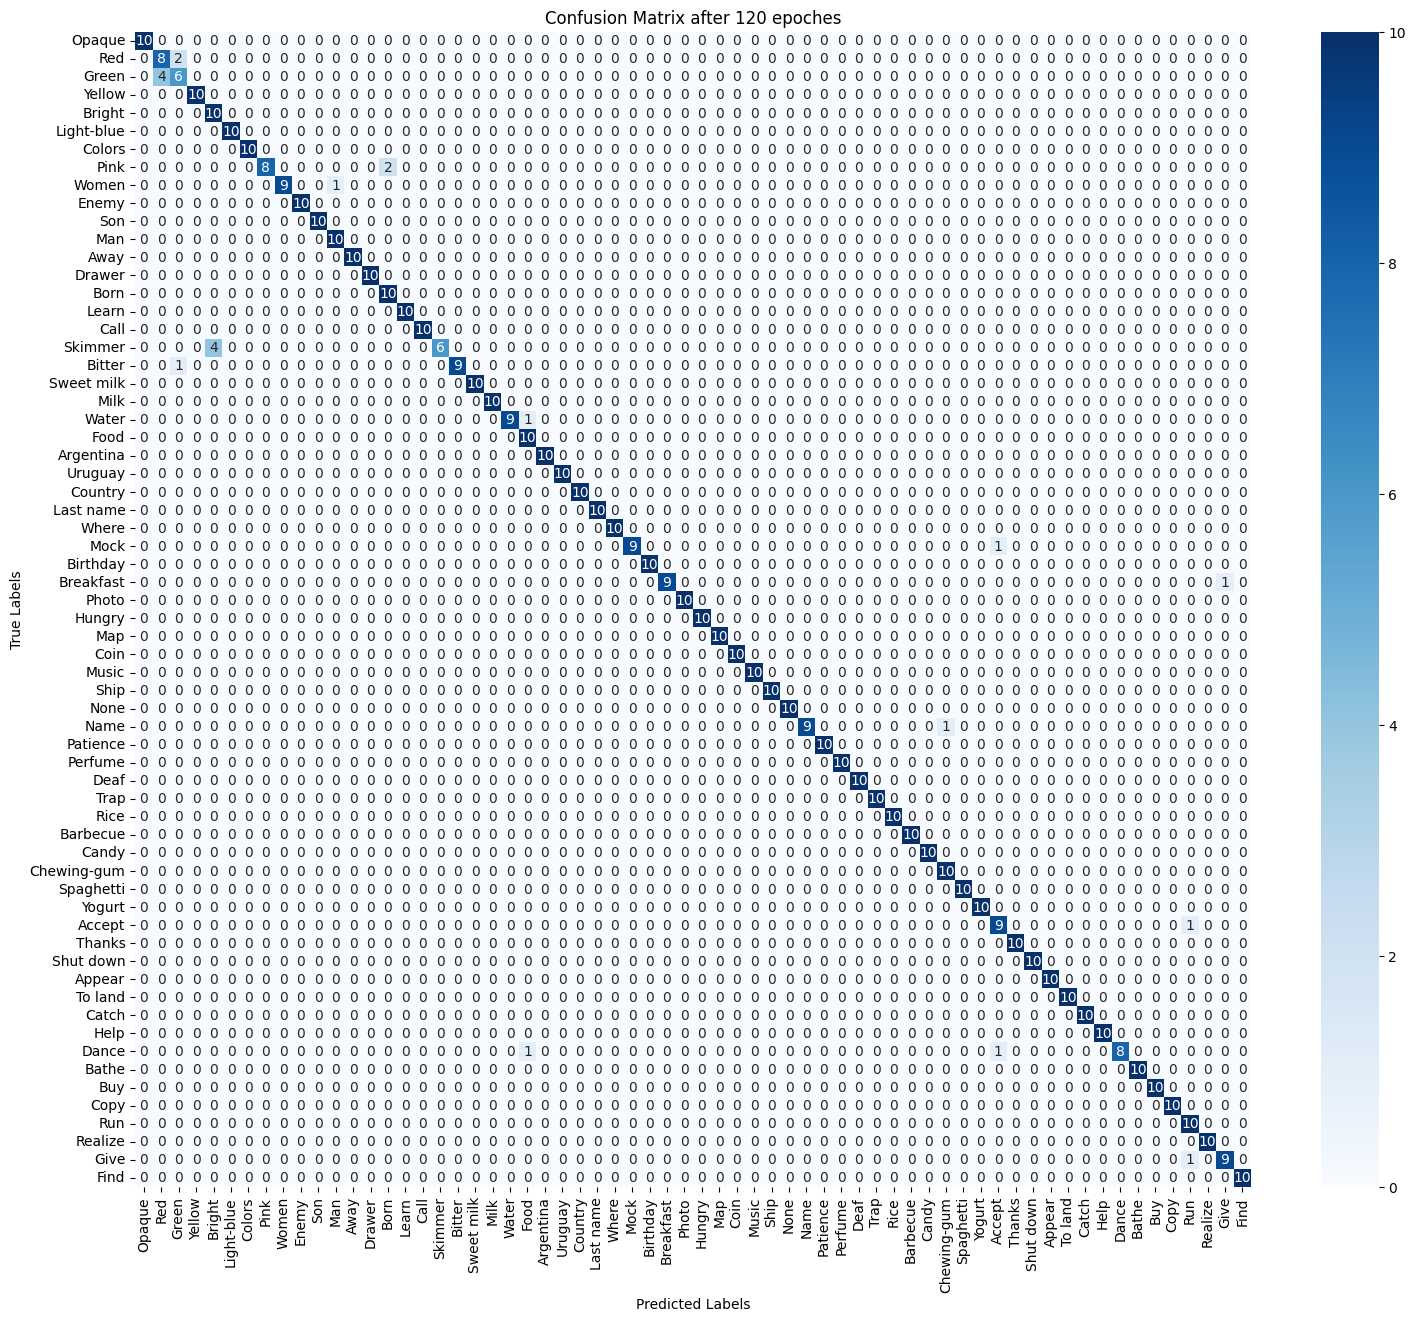

In [48]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)

# 3. Transformer with Conv1D

In [49]:
num_epochs= 120
batch_size= 64
learning_rate= 0.0001

transformer_modelc= TransformerModelC().to(device)                  # initialize model

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_modelc.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, transformer_modelc, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/120 [00:00<?, ?it/s]

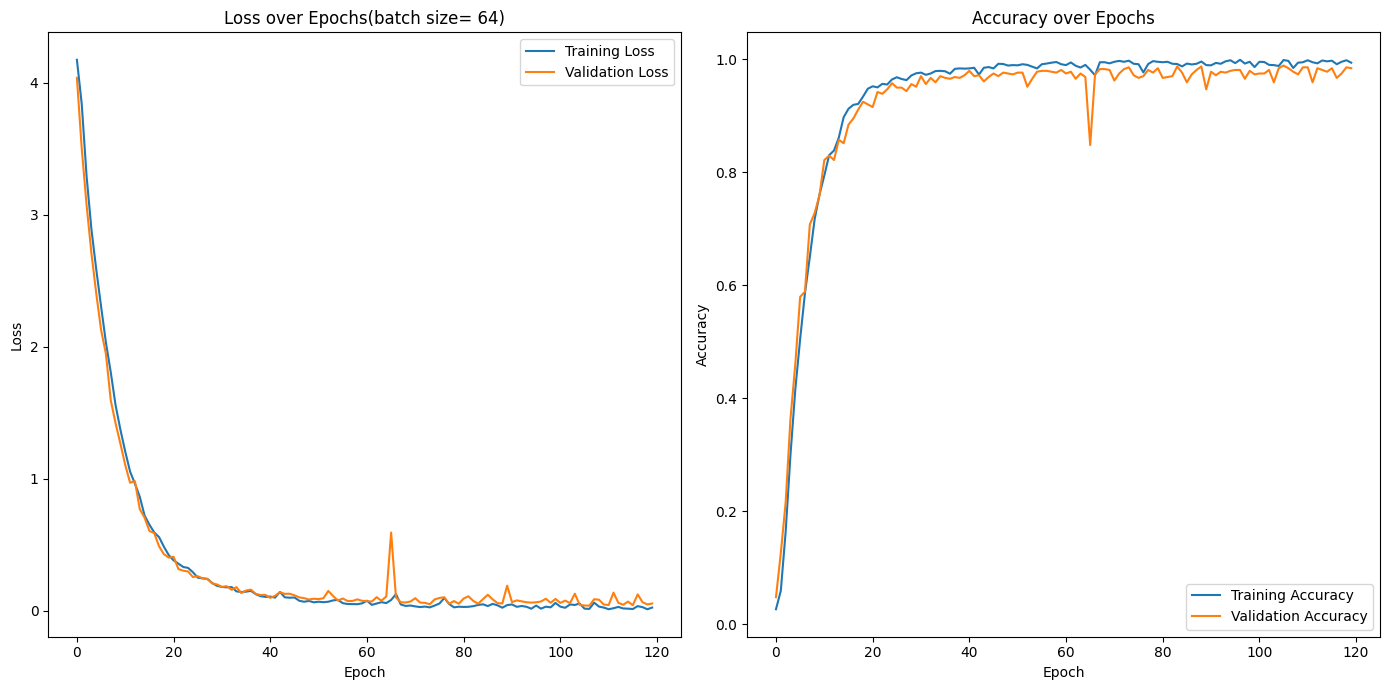

In [50]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

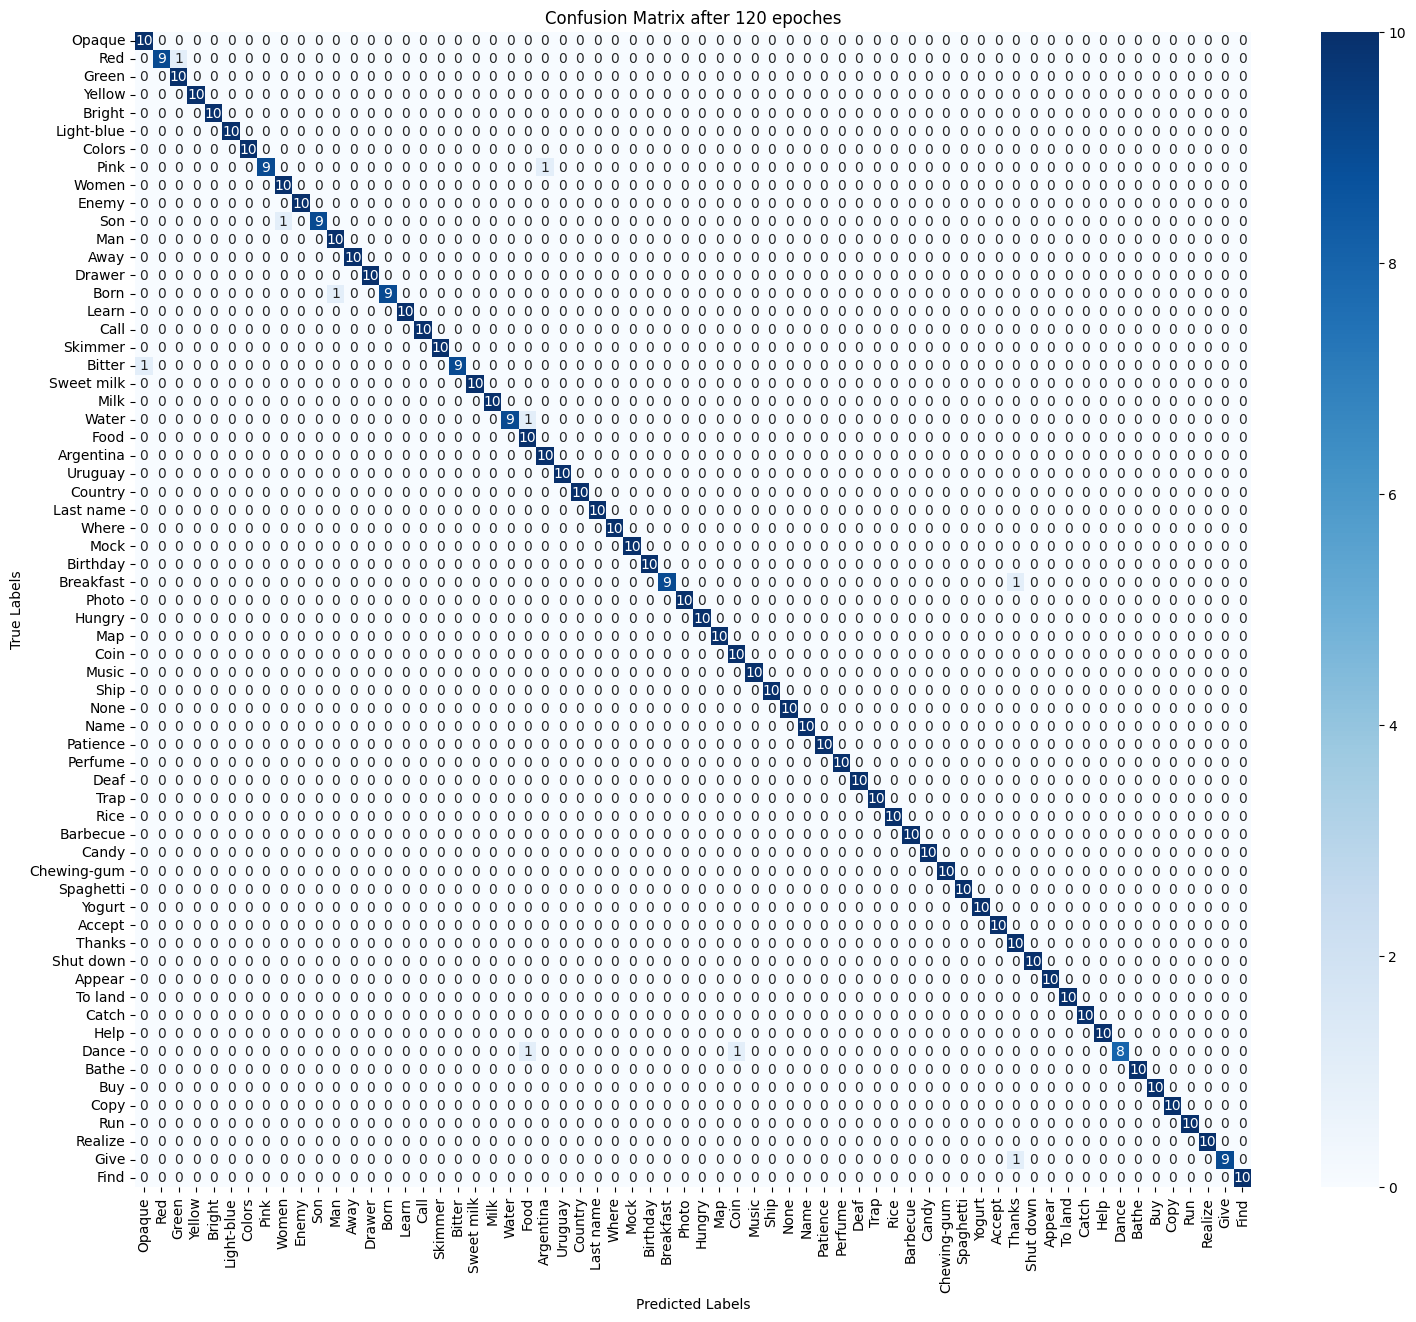

In [51]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)

# 4. Transformer with no positional encoding

In [52]:
num_epochs= 100
batch_size= 128
learning_rate= 0.0001

transformer_model= TransformerModel().to(device)                  # initialize model

train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr= learning_rate)

train_losses, test_losses, train_accuracies, test_accuracies, all_preds, all_labels = train(num_epochs, transformer_model, train_dataloader, test_dataloader, optimizer, criterion, calculate_accuracy, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

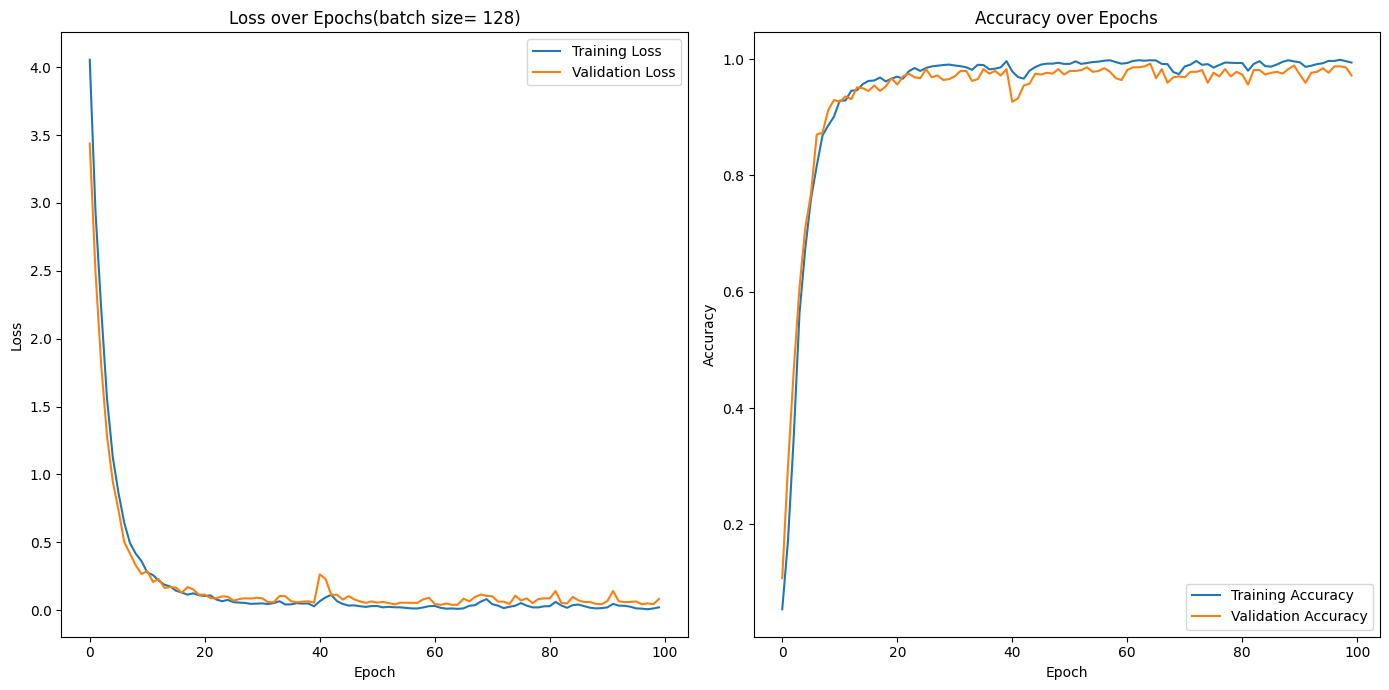

In [53]:
draw_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)

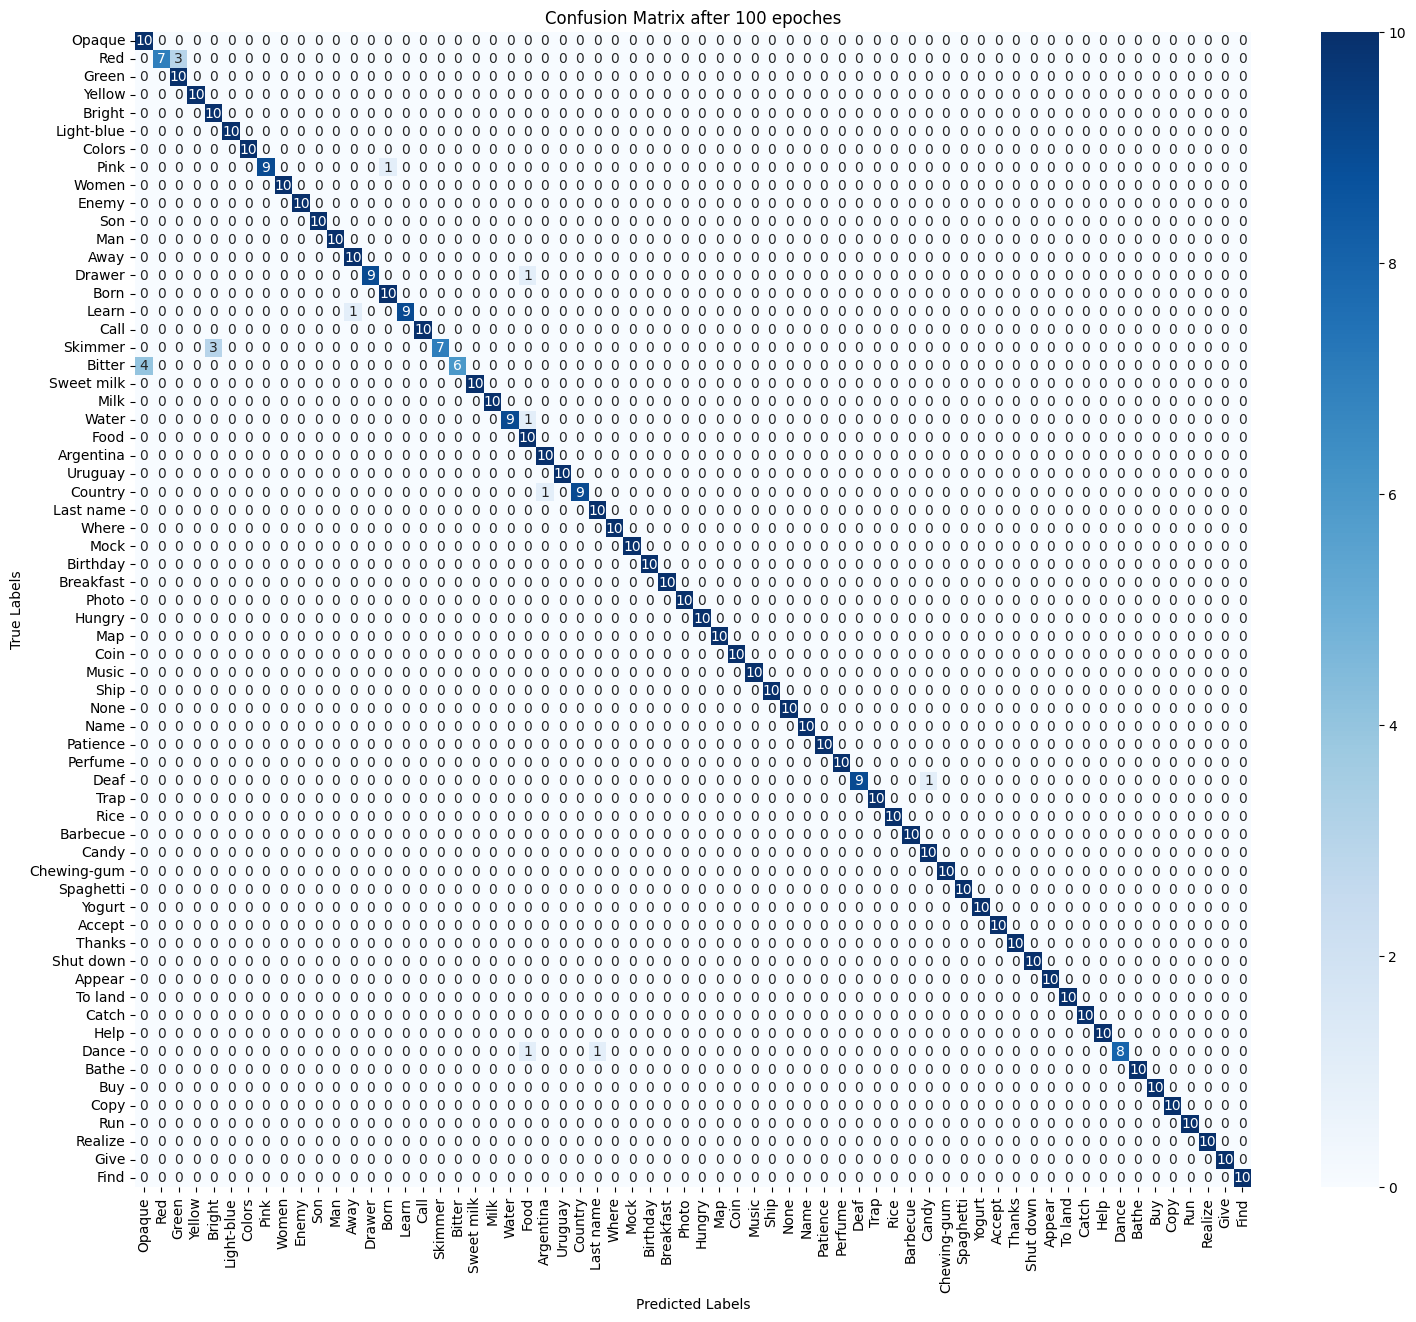

In [57]:
draw_confmatrix(all_labels, all_preds, class_names, num_epochs)

# 6. RF

In [58]:
accuracy = random_forest_model.score(x_test_reshaped, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9625


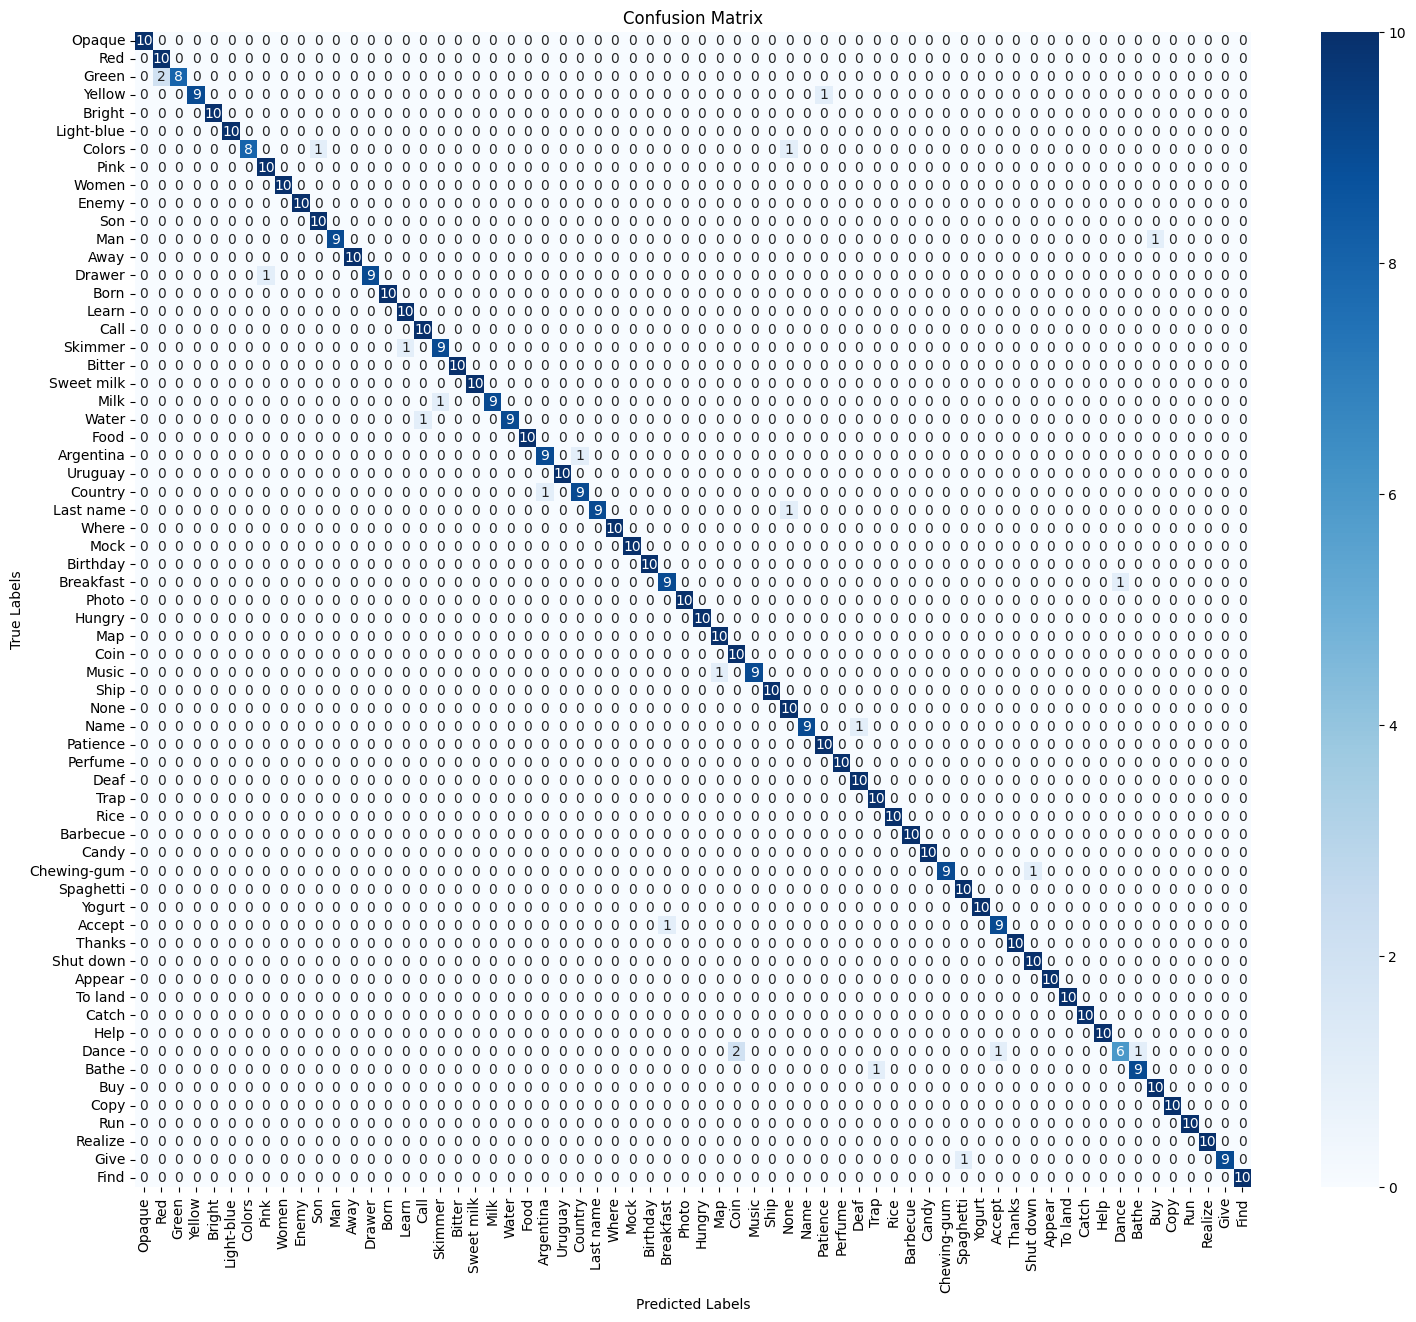

In [59]:
predictions = random_forest_model.predict(x_test_reshaped)

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
# Visualize confusion matrix
plt.figure(figsize=(18, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()